         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

/tmp/ipython-input-3014489944.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'M':1, 'B':0})


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score (CV): 0.9758241758241759
Test Accuracy (Best Model): 0.9736842105263158


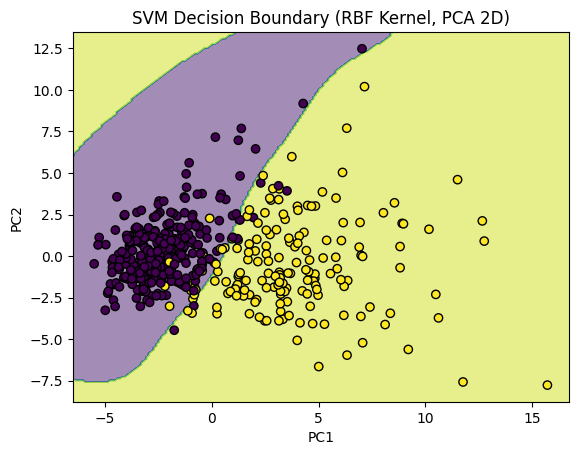

Confusion Matrix:
 [[72  0]
 [ 3 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv("/content/breast-cancer.csv")

print(df.head())
print(df.info())

# Basic cleaning
df = df.loc[:, ~df.columns.str.contains('id|Unnamed', case=False)]

# Correctly identify features (X) and target (y)
y = df['diagnosis']
X = df.drop('diagnosis', axis=1)

if y.dtype == 'object':
    y = y.replace({'M':1, 'B':0})

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear SVM
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_train_scaled, y_train)

y_pred_lin = svm_linear.predict(X_test_scaled)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_lin))

# RBF SVM
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svm_rbf.predict(X_test_scaled)
print("RBF SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score (CV):", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
print("Test Accuracy (Best Model):", accuracy_score(y_test, y_pred_best))

# PCA for visualization
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

model_vis = SVC(kernel='rbf', C=1, gamma='scale')
model_vis.fit(X_train_2D, y_train)

x_min, x_max = X_train_2D[:,0].min()-1, X_train_2D[:,0].max()+1
y_min, y_max = X_train_2D[:,1].min()-1, X_train_2D[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(X_train_2D[:,0], X_train_2D[:,1], c=y_train, edgecolors='k')
plt.title("SVM Decision Boundary (RBF Kernel, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))